In [25]:
import torch
from sklearn.metrics import accuracy_score
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

input_x1 = pd.read_csv('df1_smallestdata.csv')
input_x2 = pd.read_csv('df2_smallestdata.csv')
target_y = pd.read_csv('targets_smallestdata.csv')
input_x1 = input_x1.drop(columns=['ResponseID', 'CrossingSignal', 'NumberOfCharacters', 'Saved', 'LeftHand'])
input_x2 = input_x2.drop(columns=['ResponseID', 'CrossingSignal', 'NumberOfCharacters', 'Saved', 'LeftHand'])
feature_names = input_x1.columns.tolist()  # Get feature names from the DataFrame

input_x1 = input_x1.to_numpy()
input_x2 = input_x2.to_numpy()
target_y = target_y.to_numpy()


In [26]:
import torch
import torch.nn as nn
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(20, 16)
        self.fc2 = nn.Linear(16, 9)
        self.fc3 = nn.Linear(9, 3)
        self.fc4 = nn.Linear(3, 1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)



    def forward(self, x1, x2):
        # Element-wise subtraction
        x = x1 - x2
        # Forward pass with shared weights
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        x = self.fc4(x)
        return x

    def loss(self, output, target):
        return self.criterion(output, target)

    def backward(self, loss):
        loss.backward()

    def train_step(self, x1, x2, target):
        # Forward pass
        output = self.forward(x1, x2)
        # Compute the loss
        loss = self.loss(output, target)
        # Zero the gradients
        self.optimizer.zero_grad()
        # Backward pass
        self.backward(loss)
        # Update the weights
        self.optimizer.step()
        return loss



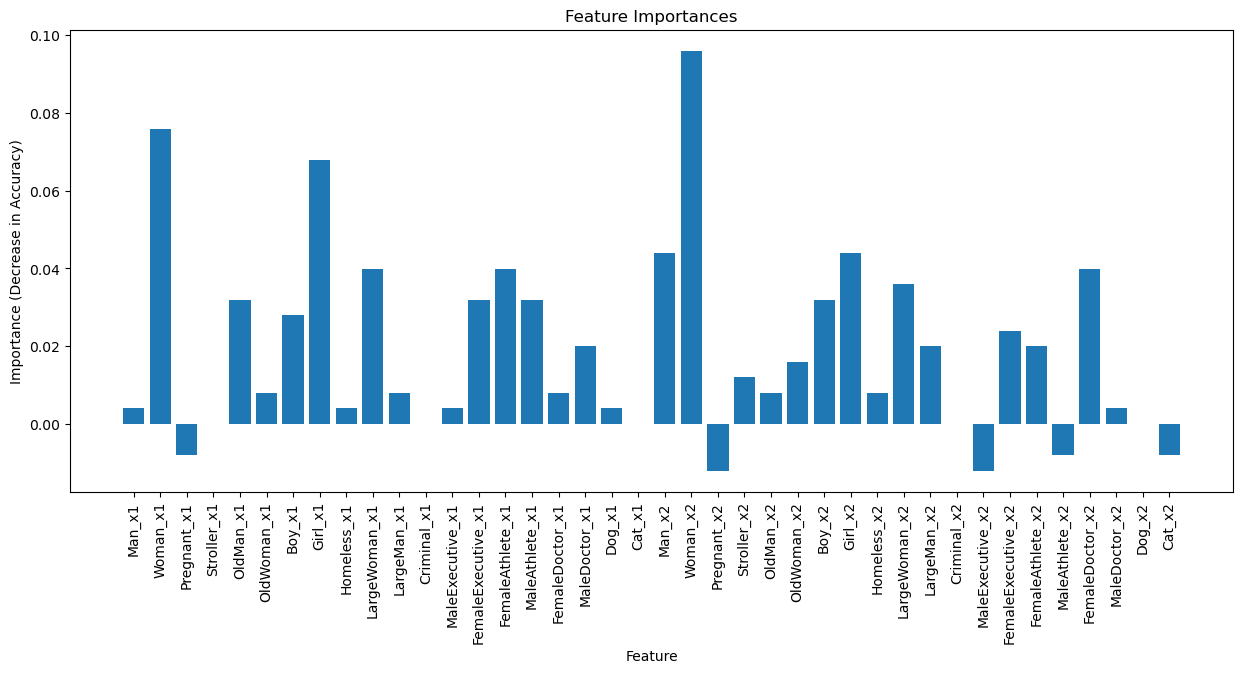

In [29]:
#load the trained PyTorch model
model_path = 'trained_sample.pth'
model = torch.load(model_path, map_location=torch.device('cpu'))
model.eval()


X_test1 = torch.tensor(input_x1, dtype=torch.float32)
X_test2 = torch.tensor(input_x2, dtype=torch.float32)
y_test = torch.tensor(target_y, dtype=torch.float32)

#move tensors to the device
device = torch.device('cpu')  # or 'cuda' if using GPU
X_test1 = X_test1.to(device)
X_test2 = X_test2.to(device)
y_test = y_test.to(device)

#calculate original accuracy
with torch.no_grad():
    original_accuracy = accuracy_score(y_test.cpu().numpy(), model(X_test1, X_test2).cpu().numpy().round())

#dictionary to store feature importances
feature_importances = {}

for feature in range(X_test1.shape[1]):
    #clone and shuffle individual feature in X_test1
    X_test1_permuted = X_test1.clone().detach()
    X_test1_permuted[:, feature] = X_test1_permuted[torch.randperm(X_test1_permuted.size(0))][:, feature]

    #accuracy with the permuted X_test1 and original X_test2
    with torch.no_grad():
        permuted_output = model(X_test1_permuted, X_test2).cpu().numpy().round()
        permuted_accuracy = accuracy_score(y_test.cpu().numpy(), permuted_output)

    feature_importances[f'x1_feature_{feature}'] = original_accuracy - permuted_accuracy

for feature in range(X_test2.shape[1]):
    #clone and shuffle individual feature in X_test2
    X_test2_permuted = X_test2.clone().detach()
    X_test2_permuted[:, feature] = X_test2_permuted[torch.randperm(X_test2_permuted.size(0))][:, feature]

    #accuracy with the permuted X_test2 and original X_test1
    with torch.no_grad():
        permuted_output = model(X_test1, X_test2_permuted).cpu().numpy().round()
        permuted_accuracy = accuracy_score(y_test.cpu().numpy(), permuted_output)

    feature_importances[f'x2_feature_{feature}'] = original_accuracy - permuted_accuracy


# Number of features in x1 (assuming x1 and x2 have the same number of features)
num_features_x1 = len(feature_names)

# Create a combined list of feature names for both X_test1 and X_test2
combined_feature_names = [f"{name}_x1" for name in feature_names] + [f"{name}_x2" for name in feature_names]

# Update the keys in feature_importances dictionary
updated_feature_importances = {}
for key, value in feature_importances.items():
    parts = key.split('_')
    feature_index = int(parts[-1])

    # Adjust feature_index for x2 features
    if 'x2' in parts:
        feature_index += num_features_x1

    actual_feature_name = combined_feature_names[feature_index]
    updated_feature_importances[actual_feature_name] = value

# Plotting the feature importances with actual feature names
plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
plt.bar(updated_feature_importances.keys(), updated_feature_importances.values())
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance (Decrease in Accuracy)')
plt.title('Feature Importances')
plt.show()